In [1]:
# Purpose: compare 3 planet datasets from the same satellites, from 2 consecutive days

# For general data processing
import shapely
import numpy as np
from math import floor

# For general file I/O
import rasterio as rio
import sys
import os.path

# For parsing xml files, which hold lat long data
import xml.etree.ElementTree as ET

# For viewing images
import sys
import skimage.io
import skimage.viewer
from matplotlib import pyplot as plt

D:\Ian\Applications\Anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Ian\Applications\Anaconda\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [17]:
# would be great to have this in another file
# This code is original, but some parts are pieced together from various forums (StackOverflow, RealPython, geeksforgeeks, etc)
def import_tif(file_base, file_ext = "_3B_AnalyticMS_SR.tif"):
    # Import planet data using their standard formats. Idea is to simply input the folder name and be done.
    
    # File base: the date_####_sat#, AKA the name of the folder
    # file_ext: the end of the filename, so you can specify which tif you want.
    # Assumed to be the MSSR data, because that's mostly what I'll be looking at..
    
    # Use context managers (eventually)
    # context managers2
    # with rio.open(tif) as src:
    #   var1 = ...
    #   var2 = ...
    #   return var1, var2
    # filename: filename to import from ./data/, or an absolute path
    
    if '\\' in file_base or '/' in file_base:
        return rio.open(filename)
    
    # Create a system-specific path to the file
    base_path = sys.path[0]
    data_folder = 'data'
    abs_file_path = os.path.join(base_path, data_folder, file_base, (file_base + file_ext))
    
    return rio.open(abs_file_path)


def import_xml(file_base, file_ext = "_3B_AnalyticMS_metadata.xml"):
    # Import all data from a specifified xml file; assume ./data if absolute path not specified
    
    if '\\' in file_base or '/' in file_base:
        return ET.parse(file_base)
    
    # Create a system-specific path to the file
    base_path = sys.path[0]
    data_folder = 'data'
    abs_file_path = os.path.join(base_path, data_folder, file_base, (file_base + file_ext))
    
    return ET.parse(abs_file_path)

    
def get_coordinates(tree):
    # Given a planet data tree, get the corner coordinates and return them as tuples.
    # root[3] = "target"; root[3][0] = "Footprint"; root[3][0][2] = "geographicLocation"
    # root[3][0][2][x] = "specified corner position; 0 = topLeft; + => CW"
    
    root = tree.getroot()
    
    # Extract the coordinates, return as a 4x1 array of tuples
    top_left = [float(root[3][0][2][0][0].text), float(root[3][0][2][0][1].text)]
    top_right = [float(root[3][0][2][1][0].text), float(root[3][0][2][1][1].text)]
    bottom_right = [float(root[3][0][2][2][0].text), float(root[3][0][2][2][1].text)]
    bottom_left = [float(root[3][0][2][3][0].text), float(root[3][0][2][3][1].text)]
    
    return top_left, top_right, bottom_right, bottom_left


def mark_point(arr, point, size = 50):
    # Mark a point
    
    marked_arr = arr.copy() # probably unecessary
    marked_arr[point[0]-size:point[0]+size, point[1]-size:point[1]+size] = 1.0
    return marked_arr


def parse_planet_data(filename):
    # Combine common functions that are usually run when analyzing planet data of this type.
    
    # Import the raw tif data
    src = import_tif(filename)
    
    # Convert to float 0.0 - 1.0, for ease of use
    arr = src.read(1) / 10000
    
    # Import the xml and extract coordinates
    xml = import_xml(filename)
    coords = get_coordinates(xml)
    
    return src, arr, xml, coords
    
    
def plot_sidebyside(data1, data2, data3, size = 30):
    # Here to clean up code and allow for flexibility in plots. Not meant for reproducability.
    
    f = plt.figure(figsize=(size,size))
    
    # Add each plot. subplots allow it to be side by side instead of on top of eachother.
    f.add_subplot(1,3, 1)
    plt.imshow(data1, cmap = 'pink')
    
    f.add_subplot(1,3, 2)
    plt.imshow(data2, cmap = 'pink')
    
    f.add_subplot(1,3, 3)
    im = plt.imshow(data3, cmap = 'pink')
    
    # Make the colorbar match the size of the plot.
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.show(block=True)
    return


def get_pixel_position(arr, coords, point):
    # Compute the row pixel:
    arr_height = arr.shape[0]
    lattitude_height = abs(coords[0][0] - coords[3][0])
    height_frac = abs((coords[0][0] - point[0]) / lattitude_height)
    print(height_frac)
    pix_row = floor(arr_height * height_frac)
    
    # Compute the col pixel:
    arr_length = arr.shape[1]
    longitude_length = abs(coords[1][1] - coords[0][1])
    length_frac = abs((coords[0][1] - point[1]) / longitude_length)
    print(length_frac)
    
    pix_col = floor(arr_length * length_frac)
    
    return pix_row, pix_col

In [18]:
# Declare initial dataset names
east_filename = "20190924_173722_67_1061"
west_filename = "20190925_174037_27_1065"
north_filename = "20190925_174107_53_105c"

# Define constants that will be used throughout.
# Did it this way so it should work with any planet dataset of this type.
# X_src: full tif import using rio.open (not yet using context managers)
# X_arr: float array 0.0 -> 0.1 of the MSSR data
# X_xml: full xml file using ET.parse
# X_coords: list of tuples containing the [topLeft, topRight, bottomRight, bottomLeft] (lat, long) coordinates
east_src, east_arr, east_xml, east_coords = parse_planet_data(east_filename)
west_src, west_arr, v_xml, west_coords = parse_planet_data(west_filename)
north_src, north_arr, north_xml, north_coords = parse_planet_data(north_filename)

In [19]:
POI = [39.85, -104.17]
east_pixel_pos = get_pixel_position(east_arr, east_coords, POI)
west_pixel_pos = get_pixel_position(west_arr, west_coords, POI)
north_pixel_pos = get_pixel_position(north_arr, north_coords, POI)

0.5438769321718874
0.7241994511969803
0.7164025008565509
0.1937543517182418
0.3728620041079934
0.8714547807275496


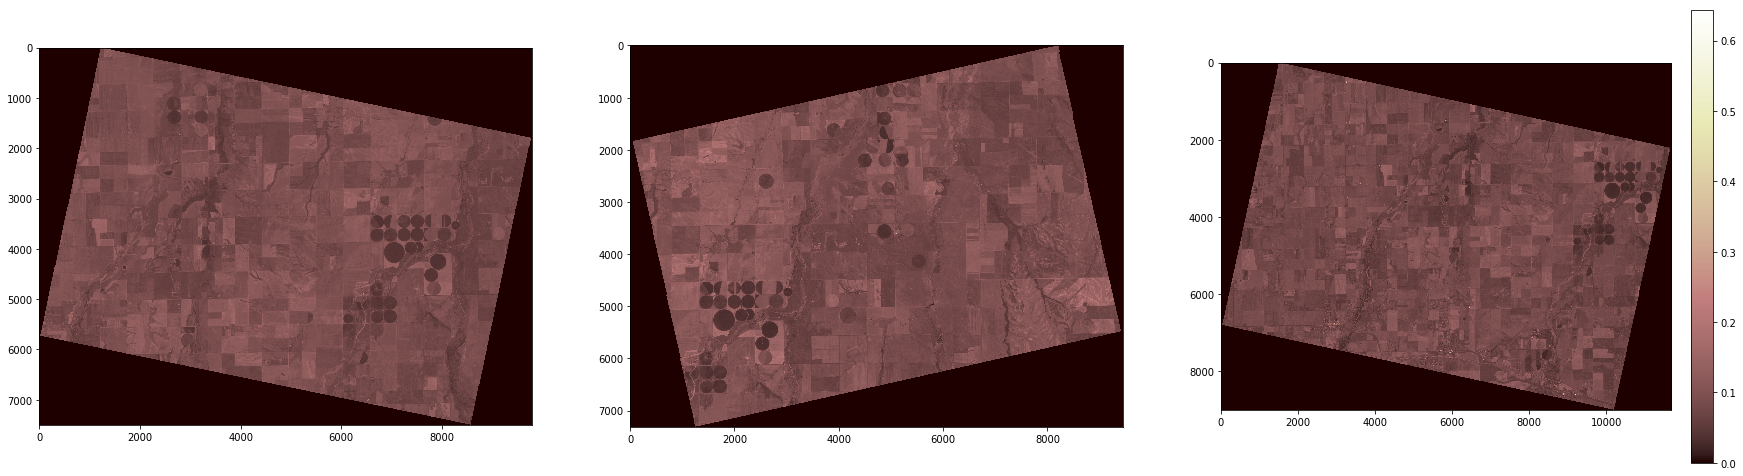

In [20]:
east_arr_marked = mark_point(east_arr, east_pixel_pos)
west_arr_marked = mark_point(west_arr, west_pixel_pos)
north_arr_marked = mark_point(north_arr, north_pixel_pos)

plot_sidebyside(east_arr, west_arr, north_arr)


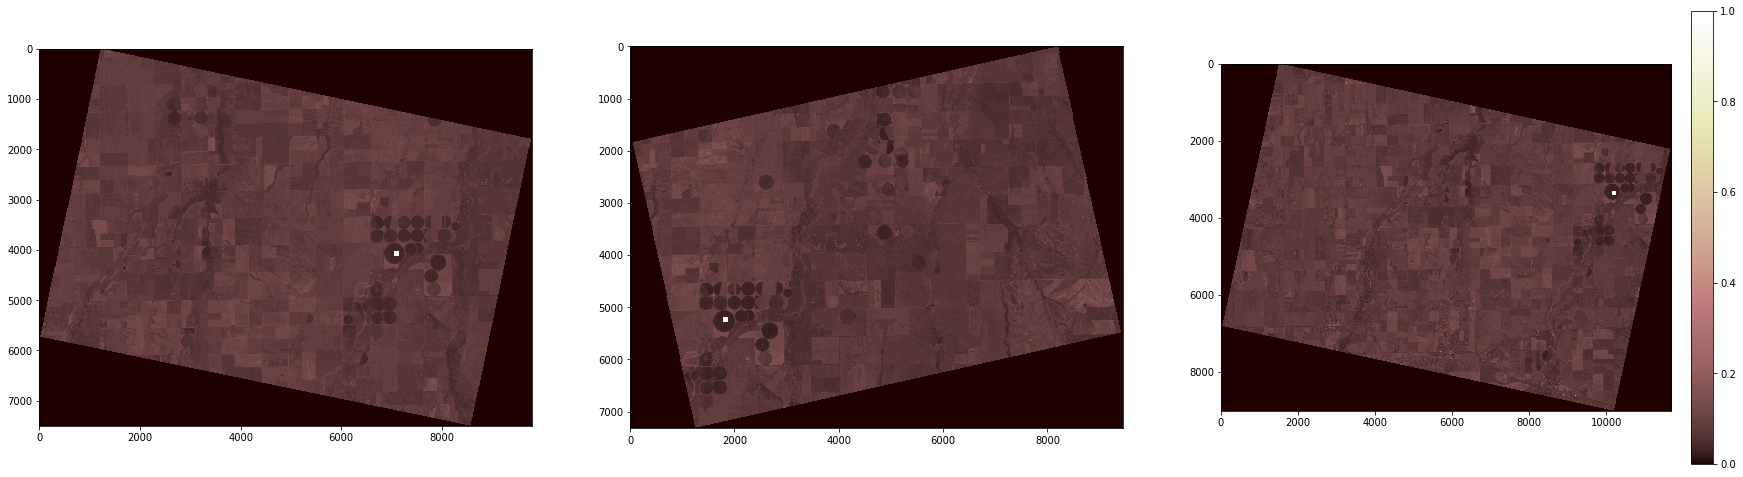

In [21]:
plot_sidebyside(east_arr_marked, west_arr_marked, north_arr_marked)



NameError: name 'a' is not defined

In [60]:

east_arr[0,0]
target_latlong = (104.17, 39.86)
print(target_latlong)
type(target_latlong)

west_affine = west_src.profile['transform']
col, row = ~west_affine * target_latlong

print(col)
print(row)
east_arr.shape

(104.17, 39.86)
-188447.27666666667
1475724.7133333334


(7502, 9786)

In [5]:
west_src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 9441, 'height': 7319, 'count': 4, 'crs': CRS.from_dict(init='epsg:32613'), 'transform': Affine(3.0, 0.0, 565446.0,
       0.0, -3.0, 4427214.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

In [48]:
north_src.profile['transform']
west_arr.max()

0.5142

In [7]:
profile = src.profile
profile.keys()
affine = profile['transform']
affine
# affine transform geospatial image. generally:
#[pixel size x, 0, lat 
# 0, pixel size y, long]
# mask 0's out 
# maskarray module

# get important xml data out
# make a mask for each and apply them all to eachother

NameError: name 'src' is not defined

In [ ]:
a = get_pixel_position(east_arr, east_coords, [39.86, -104.17])

point = [39.855, -104.24]
lattitude_height = abs(east_coords[0][0] - east_coords[3][0])
print(lattitude_height)
print(a)